<a href="https://colab.research.google.com/github/valeriocardoso/learning-area/blob/master/Machine_Learning/tabnet_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pytorch-tabnet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
wget is already the newest version (1.19.4-1ubuntu2.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [5]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
#import wget
from pathlib import Path

# Download census-income dataset

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [8]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

NameError: ignored

# Load data and split

In [9]:
train = pd.read_csv(url)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [11]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

 State-gov 9
 Bachelors 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 United-States 42
 <=50K 2
Set 3


# Define categorical features for categorical embeddings

In [12]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]

# Network parameters

In [13]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

Device used : cpu


# Training

In [14]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

In [15]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [16]:
clf.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
) 

Will train until validation stopping metric hasn't improved in 50 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | -0.17045 |  -0.86570 |   3.1       
| 2     | -0.13398 |  -0.20867 |   6.1       
| 3     | -0.12756 |  -0.17134 |   9.0       
| 4     | -0.12095 |  -0.17055 |   11.9      
| 5     | -0.11727 |  -0.13422 |   14.9      
| 6     | -0.11426 |  -0.12485 |   17.8      
| 7     | -0.11170 |  -0.11234 |   20.8      
| 8     | -0.11031 |  -0.11402 |   23.8      
| 9     | -0.10903 |  -0.10687 |   26.7      
| 10    | -0.10790 |  -0.10859 |   29.6      
| 11    | -0.10747 |  -0.10499 |   32.5      
| 12    | -0.10813 |  -0.10386 |   35.4      
| 13    | -0.10625 |  -0.10199 |   38.3      
| 14    | -0.10485 |  -0.10296 |   41.3      
| 15    | -0.10464 |  -0.10235 |   44.1      
| 16    | -0.10448 |  -0.10380 |   47.0      
| 17    | -0.10518 |  -0.10203 |   49.9      
| 18    | -0.10385 |  -0.10125 |   52.8      
| 19    | -0

In [17]:
# Deprecated : best model is automatically loaded at end of fit
# clf.load_best_model()

preds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_score}")

BEST VALID SCORE FOR census-income : 0.09718684107065201
FINAL TEST SCORE FOR census-income : 0.1008398534155765


# Global explainability : feat importance summing to 1

In [18]:
clf.feature_importances_

array([2.41163807e-07, 5.70017752e-03, 3.86150353e-03, 2.75508057e-02,
       1.24639369e-01, 1.67086504e-01, 1.97541626e-01, 6.47483167e-02,
       2.61175313e-02, 1.85789089e-02, 2.93305728e-01, 4.98292101e-02,
       3.94196921e-04, 2.06458810e-02])

# Local explainability and masks

In [19]:
explain_matrix, masks = clf.explain(X_test)

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline

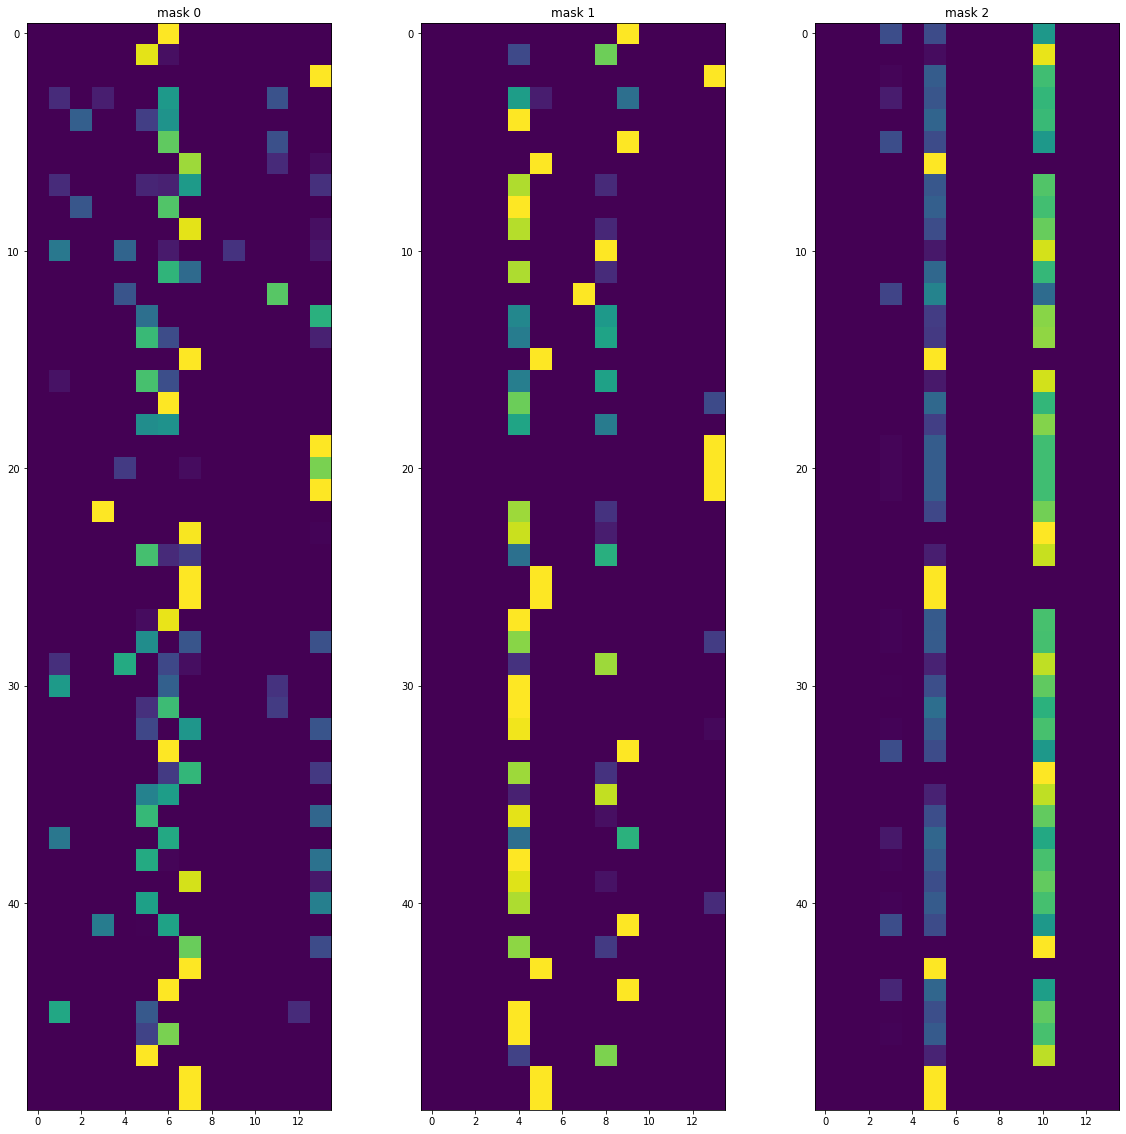

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [22]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-rmse:0.469925
Will train until validation_0-rmse hasn't improved in 40 rounds.
[10]	validation_0-rmse:0.33056
[20]	validation_0-rmse:0.302744
[30]	validation_0-rmse:0.296757
[40]	validation_0-rmse:0.295143
[50]	validation_0-rmse:0.295199
[60]	validation_0-rmse:0.294966
[70]	validation_0-rmse:0.295182
[80]	validation_0-rmse:0.295209
[90]	validation_0-rmse:0.295743
[100]	validation_0-rmse:0.295986
Stopping. Best iteration:
[62]	validation_0-rmse:0.294846



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7, verbosity=0)

In [23]:
preds = np.array(clf_xgb.predict(X_valid))
valid_auc = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict(X_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_auc)

0.08693414448412666
0.09148940929290396
